In [1]:
#-*-coding:utf-8-*-

%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torchvision

import cv2

import copy

import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
%matplotlib inline

__ROOT_PATH = os.path.abspath('../../')
sys.path.append(__ROOT_PATH)

matplotlib.rcParams['figure.facecolor'] = 'w'

In [2]:
from csgan.loader.colored_mnist_loader import ColoredMnistDataset
from csgan.model.cs_double_encoder_model import CSDoubleEconderMnistModel

In [3]:
DATA_ROOT = os.path.join(__ROOT_PATH, "data/")
RUN_ROOT = os.path.join(__ROOT_PATH, "runs/")

In [4]:
run_dir = os.path.join(RUN_ROOT, "mnist_cs_double_encoder/")
os.makedirs(run_dir, exist_ok=True)

params = {'seed': 2222, 'num_epoch': 200, 'batch_size': 32, 'test_batch_size': 512,
          'learning_rate': 0.0002, 'beta1': 0.5, 'beta2': 0.999,
          'scheduler_gamma': 1., 'weight_decay': 0., #0.00001,
          'lambda_identity': 5., 'lambda_cycle': 10., 'lambda_content': 0.1, 'lambda_style': 0.,
          'lambda_source': 0.1, 'lambda_reference': 0.1, 'lambda_content_seg': 0., 'lambda_style_seg': 0.,
          'lambda_siamese': 0.,
          'gamma_content': 1., 'gamma_style': 1., 'gamma_source': 1., 'gamma_reference': 1.,
          'gamma_content_seg': 1., 'gamma_style_seg': 1., 
          'scheduler_interval': 1000, 'checkpoint_interval': 10,
          'validation_interval': 10, 'logging_interval': 10, 'sampling_interval': 100,
          'stopping_loss': 'loss',
          'run_dir': run_dir}

In [13]:
from torch import nn
l = nn.MSELoss()
print(isinstance(l, nn.MSELoss))
print(isinstance(l, nn.BCEWithLogitsLoss))
l = nn.BCEWithLogitsLoss()
print(isinstance(l, nn.MSELoss))
print(isinstance(l, nn.BCEWithLogitsLoss))

True
False
False
True


In [5]:
train_dataset = ColoredMnistDataset(root=DATA_ROOT, train=True)
test_dataset = ColoredMnistDataset(root=DATA_ROOT, train=False)
print(len(train_dataset), len(test_dataset))

60000 10000


In [6]:
train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, params['test_batch_size'], shuffle=False, drop_last=False)
print(len(train_loader), len(test_loader))

1875 20


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cs_model = CSDoubleEconderMnistModel(device)
#cs_model.load(os.path.join(run_dir, 'best_model.pth.tar'))
cs_model.train_model(train_loader, params=params)


Learning with learning rate:  0.00020000.

[1/200] 10'th step. [LOSS] 4.892775. [LOSS_IDENTITY] 2.371507. [LOSS_CYCLE] 2.276603. [LOSS_CONTENT] 0.075945. [ACCURACY_CONTENT] 0.515625. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SOURCE] 0.080868. [ACCURACY_SOURCE] 0.390625. [LOSS_REFERENCE] 0.072422. [ACCURACY_REFERENCE] 0.531250. [LOSS_CONTENT_SEG] 0.000000. [ACCURACY_CONTENT_SEG] 0.500000. [LOSS_STYLE_SEG] 0.000000. [ACCURACY_STYLE_SEG] 0.500000. [LOSS_SIAMESE] 0.000000. [NORM_S1] 1.516743. [NORM_S2] 1.548631
    Best Step:     10. Elapsed Time: 6.217882 seconds.
[1/200] 20'th step. [LOSS] 3.113529. [LOSS_IDENTITY] 1.442293. [LOSS_CYCLE] 1.403430. [LOSS_CONTENT] 0.072052. [ACCURACY_CONTENT] 0.546875. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SOURCE] 0.093072. [ACCURACY_SOURCE] 0.250000. [LOSS_REFERENCE] 0.084748. [ACCURACY_REFERENCE] 0.359375. [LOSS_CONTENT_SEG] 0.000000. [ACCURACY_CONTENT_SEG] 0.500000. [LOSS_STYLE_SEG] 0.000000. [ACCURACY_STYLE_SEG] 0.50000

C:\Users\User\Anaconda3\envs\pytorch3\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Learning with learning rate:  0.00020000.

[1/200] 1000'th step. [LOSS] 0.817130. [LOSS_IDENTITY] 0.211299. [LOSS_CYCLE] 0.265614. [LOSS_CONTENT] 0.070033. [ACCURACY_CONTENT] 0.515625. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SOURCE] 0.036415. [ACCURACY_SOURCE] 0.734375. [LOSS_REFERENCE] 0.046068. [ACCURACY_REFERENCE] 0.750000. [LOSS_CONTENT_SEG] 0.000000. [ACCURACY_CONTENT_SEG] 0.500000. [LOSS_STYLE_SEG] 0.000000. [ACCURACY_STYLE_SEG] 0.500000. [LOSS_SIAMESE] 0.000000. [NORM_S1] 1.530130. [NORM_S2] 4.793786
    Best Step:   1000. Elapsed Time: 231.817578 seconds.
[1/200] 1010'th step. [LOSS] 0.614621. [LOSS_IDENTITY] 0.183985. [LOSS_CYCLE] 0.228645. [LOSS_CONTENT] 0.068552. [ACCURACY_CONTENT] 0.546875. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SOURCE] 0.043946. [ACCURACY_SOURCE] 0.843750. [LOSS_REFERENCE] 0.038095. [ACCURACY_REFERENCE] 0.890625. [LOSS_CONTENT_SEG] 0.000000. [ACCURACY_CONTENT_SEG] 0.500000. [LOSS_STYLE_SEG] 0.000000. [ACCURACY_STYLE_SEG] 0

KeyboardInterrupt: 

In [ ]:
all_input, all_output = cs_model.predict(test_loader)

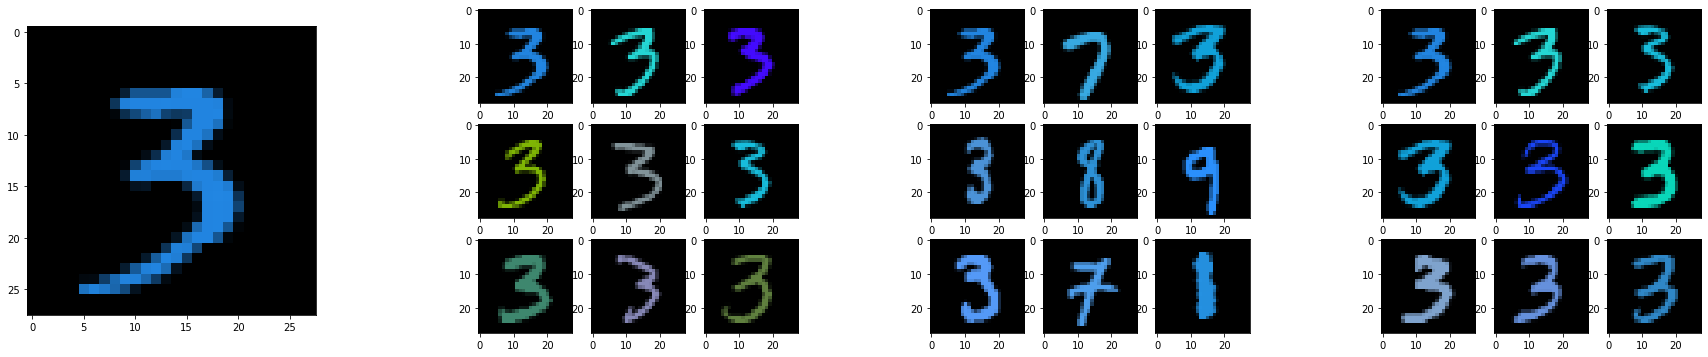

In [17]:
images = all_input['x2'].numpy().transpose(0, 2, 3, 1)
latents = all_output['z2'].numpy()
styles = all_output['s2'].numpy()
contents = all_output['c2'].numpy()

index = np.random.randint(len(images))

fig = plt.figure(figsize=(30, 6))

ax = fig.add_subplot(1, 5, 1)
ax.imshow(images[index])
content_indices = ((contents-contents[index:index+1])**2).mean(axis=1).argsort(axis=0)
style_indices = ((styles-styles[index:index+1])**2).mean(axis=1).argsort(axis=0)
latent_indices = ((latents-latents[index:index+1])**2).mean(axis=1).argsort(axis=0)
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+5)
    ax.imshow(images[content_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+9)
    ax.imshow(images[style_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+13)
    ax.imshow(images[latent_indices[i]])

plt.savefig(os.path.join(__ROOT_PATH, "./results/", f"similar_test.png"), dpi=200, bbox_inches='tight')
plt.show()